# Score Éditorial Anime - Projet Final Data Science

# Importation des bibliothèques nécessaires,

Définition des chemins des dossiers,

Nom des fichiers...

In [2]:
import matplotlib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
from scipy.stats import gaussian_kde
from wordcloud import WordCloud
from collections import Counter
import re

BASE_DIR = os.path.dirname(os.getcwd())
DATA_RAW_DIR = os.path.join(BASE_DIR, "data", "raw")
PROCESSED_DIR = os.path.join(BASE_DIR, "data", "processed")
RAW_FILE = "animes_dataset.csv"
raw_path = os.path.join(DATA_RAW_DIR, RAW_FILE)
clean_path = os.path.join(PROCESSED_DIR, "animes_cleaned.csv")
IMG_DIR = os.path.join(BASE_DIR, "img")

if not os.path.exists(IMG_DIR):
    os.makedirs(IMG_DIR)

def save_graph(nom_fichier):
    chemin_complet = os.path.join(IMG_DIR, nom_fichier)
    plt.savefig(chemin_complet, bbox_inches='tight', dpi=300)
    print(f"💾 Graphique sauvegardé dans : {chemin_complet}")

# Fonction pour charger le dataset sans erreurs

In [3]:
def load_animes_dataset(file_path):
   
    try:
        df = pd.read_csv(file_path)
        print(f"Succès : Le fichier '{file_path}' a été chargé.")
        print(f"Dimensions : {df.shape[0]} lignes et {df.shape[1]} colonnes.")
        return df
    except FileNotFoundError:
        print(f"Erreur : Le fichier est introuvable au chemin : {file_path}")
        print("Vérifier que le fichier est bien dans le bon dossier.")
        raise
    except pd.errors.EmptyDataError:
        print(f"Erreur : Le fichier '{file_path}' est vide.")
        raise
    except Exception as e:
        print(f"Erreur inattendue : {e}")
        raise

df = load_animes_dataset(raw_path)

Succès : Le fichier 'c:\Users\D\Documents\Cours\Projet Data\Score_Editorial_Animes\data\raw\animes_dataset.csv' a été chargé.
Dimensions : 61 lignes et 17 colonnes.


# Aperçu du dataset

In [4]:
print("\n--- Aperçu des premières lignes ---")
print(df.head())


--- Aperçu des premières lignes ---
                              Anime           Genre_Tags    Source  \
0                            Naruto      Action / Shonen     Manga   
1                            Trigun      Sci-Fi / Action     Manga   
2                     Dragon Ball Z      Action / Shonen     Manga   
3  Fullmetal Alchemist: Brotherhood  Aventure / Military     Manga   
4                      Cowboy Bebop        Sci-Fi / Noir  Original   

   Nb_Episodes Status          Studio    Date_Pub  Note_Globale  \
0          220   Fini  Studio Pierrot  2002-10-03           8.4   
1           26   Fini        Madhouse  1998-04-01           8.2   
2          291   Fini  Toei Animation  1989-04-26           8.7   
3           64   Fini           Bones  2009-04-05           9.1   
4           26   Fini         Sunrise  1998-04-03           8.8   

   Note_Meilleur_Ep                   Meilleur_Ep_Titre  \
0               9.6           Ep 133: Le cri des larmes   
1               9.1  

In [5]:
print("\n--- Informations sur le dataset ---")
df_dataset = pd.DataFrame({
    'Type': df.dtypes,
    'Non-Nuls': df.notnull().sum(),
    'Manquantes': df.isnull().sum(),
    'Pourcentage (%)': (df.isnull().sum() / len(df)) * 100})
print(df_dataset) 


--- Informations sur le dataset ---
                      Type  Non-Nuls  Manquantes  Pourcentage (%)
Anime               object        61           0         0.000000
Genre_Tags          object        61           0         0.000000
Source              object        61           0         0.000000
Nb_Episodes          int64        61           0         0.000000
Status              object        61           0         0.000000
Studio              object        61           0         0.000000
Date_Pub            object        61           0         0.000000
Note_Globale       float64        61           0         0.000000
Note_Meilleur_Ep   float64        61           0         0.000000
Meilleur_Ep_Titre   object        61           0         0.000000
Comm_Meilleur_Ep    object        61           0         0.000000
Note_Pire_Ep       float64        61           0         0.000000
Pire_Ep_Titre       object        61           0         0.000000
Comm_Pire_Ep        object        61   

# Premières analyses du dataset à vue d'oeil grâce au .describe()

Actuellement 'Date_Pub' en 'object', on doit le convertir en 'datatime'.

Comm_Saison_3 a des manquants.

L'objectif sera de visualiser les colonnes de texte puis numériques afin de détecter certaines anomalies...


# Visualisation des contenus "Object" pour détection d'anomalies


In [6]:
df_object = df.select_dtypes(include=['object'])
pd.set_option('display.max_columns', None)  # Affiche toutes les colonnes
pd.set_option('display.max_colwidth', None) # Affiche tout le texte sans le couper
df_object

,Anime,Genre_Tags,Source,Status,Studio,Date_Pub,Meilleur_Ep_Titre,Comm_Meilleur_Ep,Pire_Ep_Titre,Comm_Pire_Ep,Comm_Saison_1,Comm_Saison_2,Comm_Saison_3
0,Naruto,Action / Shonen,Manga,Fini,Studio Pierrot,2002-10-03,Ep 133: Le cri des larmes,Animation fluide et combat viscéral incroyable.,Ep 26: Journal de Konoha (Recap),"Remplissage inutile, à sauter.","Arc Zabuza très émouvant, bases solides.",Examen Chuunin introduit une tension sombre.,Combat Lee vs Gaara légendaire.
1,Trigun,Sci-Fi / Action,Manga,Fini,Madhouse,1998-04-01,Ep 24: Le péché (Sin),"Conclusion tragique de l'arc Wolfwood, émotion pure.",Ep 13: Vash the Stampede (Recap),Résumé de mi-saison qui casse le rythme.,"Début western comique, Vash joue l'idiot.",Virage dramatique sombre avec les Gung-Ho Guns.,Révélations philosophiques sur le passé et Knives.
2,Dragon Ball Z,Action / Shonen,Manga,Fini,Toei Animation,1989-04-26,Ep 237: Le sacrifice d'un père,"Rédemption ultime de Vegeta, sommet émotionnel.",Ep 39: Amis ou ennemis (Fake Namek),"Filler ennuyeux sur une fausse planète, inutile.",Introduction des Saiyans et codes du Shonen posés.,Aventure spatiale et tension tactique sur Namek.,"Transformation Super Saiyan iconique, combat épique."
3,Fullmetal Alchemist: Brotherhood,Aventure / Military,Manga,Fini,Bones,2009-04-05,Ep 63: De l'autre côté de la porte,"Sacrifice thématique parfait, conclusion magistrale.",Ep 27: Intermède (Recap),Episode récapitulatif cassant le rythme.,"Début effréné, traumatisme Nina Tucker marquant.",Complot politique et Mustang brille contre Lust.,"Ambiance militaire froide à Briggs, tension monte."
4,Cowboy Bebop,Sci-Fi / Noir,Original,Fini,Sunrise,1998-04-03,Ep 26: The Real Folk Blues Pt.2,Fin poétique et iconique. Bang.,Ep 23: Boogie Woogie Feng Shui,Intrigue faible et rythme un peu mou.,Formation de l'équipe et choc visuel à l'église.,Exploration mélancolique du passé (Jupiter Jazz).,Confrontation fatale avec le Syndicat et Vicious.
...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,SPY×FAMILY,Comedy / Slice of Life,Manga,En cours,Wit / CloverWorks,2022-04-09,Ep 2: Secure a Wife,L'introduction de Yor. Mélange parfait d'action et comédie.,Ep 17: Carry Out the Griffon Plan,"Episode plus léger 'Slice of Life', moins d'enjeux.",La dynamique familiale Forger est le coeur de la série.,Anya est une icône de la culture anime moderne.,NaN
57,Dan Da Dan,Action / Supernatural,Manga,En cours,Science SARU,2024-10-04,Ep 7: Acrobatic Silky,Une histoire tragique et émouvante derrière le monstre.,Ep 12: Let's Go to the Cursed House,Fin de saison un peu abrupte pour certains.,Animation déjantée et créative typique de Science SARU.,"Mélange unique d'occulte, d'aliens et de romance adolescente.",NaN
58,Made in Abyss,Adventure / Mystery,Manga,En cours,Kinema Citrus,2017-07-07,Ep 13: The Challengers,Un épisode final d'une beauté et d'une cruauté absolues.,Ep 6: Incinerator,"Episode d'entraînement, nécessaire mais moins captivant.",Contraste brutal entre le design 'Chibi' et l'horreur du scénario.,Un voyage sans retour vers les profondeurs traumatisantes.,NaN
59,Kuroko's Basket,Sport / Basketball,Manga,Fini,Production I.G,2012-04-07,Ep 24: Don't Get the Wrong Idea,Kise vs Aomine. Le duel de la Génération des Miracles.,Ep 5: Your Basketball,"Mise en place de l'équipe, rythme plus lent.",Basket avec des super-pouvoirs assumés ('The Zone').,Animation fluide et intensité des matchs incomparable.,NaN


# Nettoyage du texte

In [7]:
cols_object = df.select_dtypes(include=['object']).columns
for col in cols_object:
    df[col] = df[col].str.strip()

# Harmonisation du texte pour certaines colonnes

In [8]:
cols_categories = ['Source', 'Status', 'Studio']
for col in cols_categories:
    df[col] = df[col].str.title().str.strip()

print("\n✅ Nettoyage terminé pour les colonnes de type 'object'.")
print("\n--- Contenu harmonisé de la colonne object ---")
for col in cols_categories:
    print(f"Colonne '{col}' :")
    print(*df[col].unique(), sep='\n')


✅ Nettoyage terminé pour les colonnes de type 'object'.

--- Contenu harmonisé de la colonne object ---
Colonne 'Source' :
Manga
Original
Light Novel
Web Manga
Manhwa
Visual Novel
Colonne 'Status' :
Fini
En Cours
En Pause
Colonne 'Studio' :
Studio Pierrot
Madhouse
Toei Animation
Bones
Sunrise
A-1 Pictures
White Fox
Tms Entertainment
8Bit
Production I.G
Olm
Engi
Manglobe
Wit Studio / Mappa
Ufotable
Artland
David Production
Mappa
Studio Gallop / Deen
Nexus
Cloverworks
Wit / Cloverworks
Science Saru
Kinema Citrus


# Suppression des doublons

In [9]:
df.drop_duplicates(inplace=True)
print(f"\nNombre de lignes après suppression des doublons : {len(df)}")


Nombre de lignes après suppression des doublons : 59


# Forcage des types

In [10]:
df['Date_Pub'] = pd.to_datetime(df['Date_Pub'], errors='coerce')
df['Nb_Episodes'] = pd.to_numeric(df['Nb_Episodes'], errors='coerce')
df['Note_Globale'] = pd.to_numeric(df['Note_Globale'], errors='coerce')
df['Note_Meilleur_Ep'] = pd.to_numeric(df['Note_Meilleur_Ep'], errors='coerce')
df['Note_Pire_Ep'] = pd.to_numeric(df['Note_Pire_Ep'], errors='coerce') 
print("\n✅ Conversion des colonnes numériques effectuée.")


✅ Conversion des colonnes numériques effectuée.


# Visualisation des données manquantes

In [11]:
print("\n--- Visualisation des données manquantes (NaN) ---")
colonnes_vides = df[df['Comm_Saison_3'].isnull()]
print(colonnes_vides[['Anime', 'Comm_Saison_3']])


--- Visualisation des données manquantes (NaN) ---
                        Anime Comm_Saison_3
51     The Promised Neverland           NaN
52               Chainsaw Man           NaN
53               Vinland Saga           NaN
54                 Fairy Tail           NaN
55  Mashle: Magic and Muscles           NaN
56                 SPY×FAMILY           NaN
57                 Dan Da Dan           NaN
58              Made in Abyss           NaN
59            Kuroko's Basket           NaN
60             Mob Psycho 100           NaN


# Remplissage des valeurs manquantes dans 'Comm_Saison_3'

In [12]:
df['Comm_Saison_3'] = df['Comm_Saison_3'].fillna("Information non disponible")
print("✅ Valeurs manquantes dans 'Comm_Saison_3' remplacées par 'Information non disponible'.")

✅ Valeurs manquantes dans 'Comm_Saison_3' remplacées par 'Information non disponible'.


# Visualisation des contenus "Numériques" pour détection d'anomalies
Ici on analyse les colonnes "Numériques" comme 'Note_Globale', 'Note_Meilleur_Ep' ou bien 'Nb_Episodes'...

In [13]:
print("\n--- Contenu de la colonne Numérique sélectionnée ---")
print("\nNote_Globale :")
print(df['Note_Globale'].unique())
print("\nNote_Meilleur_Ep :")
print(df['Note_Meilleur_Ep'].unique())
print("\nNote_Pire_Ep :")
print(df['Note_Pire_Ep'].unique())
print("\nNb_Episodes :")
print(df['Nb_Episodes'].unique())
number_df = df.select_dtypes(include=['number'])
print("\nRésumé statistique des colonnes numériques :")
print(number_df.describe())


--- Contenu de la colonne Numérique sélectionnée ---

Note_Globale :
[8.4 8.2 8.7 9.1 8.8 7.2 8.3 8.5 8.  8.6 9.  7.9 7.5 6.  9.3 7.7 7.6 8.9
 8.1]

Note_Meilleur_Ep :
[9.6 9.1 9.4 9.7 8.9 9.8 9.3 9.9 9.5 8.2 9.2 8.3 8.6 8.4 8.5 9.  8.7]

Note_Pire_Ep :
[5.8 6.5 5.9 6.3 7.2 7.6 7.1 5.6 6.  7.5 6.8 6.2 7.9 0.  7.8 7.4 4.3 5.5
 4.8 5.2 8.  6.9 7.3 8.4 2.7 5.3 7.7]

Nb_Episodes :
[ 220   26  291   64   25   50   57 1090   36   85   24   12    3    8
   89   37  148   43  500   41  138  366   55   48   47  293   28   13
   22   74   76   95  112   32  170   23  328   75]

Résumé statistique des colonnes numériques :
       Nb_Episodes  Note_Globale  Note_Meilleur_Ep  Note_Pire_Ep
count    59.000000     59.000000         59.000000     59.000000
mean     91.864407      8.323729          9.323729      6.703390
std     164.602181      0.523693          0.456123      1.388123
min       3.000000      6.000000          8.200000      0.000000
25%      24.000000      8.150000          9.100000    

# Remplacement des valeurs anormales dans 'Note_Pire_Ep'

In [14]:
note_pire_ep_anormales = df[df['Note_Pire_Ep'] > 0]['Note_Pire_Ep'].median()
df.loc[df['Note_Pire_Ep'] == 0, 'Note_Pire_Ep'] = note_pire_ep_anormales
print("✅ Valeurs anormales (0.0) dans 'Note_Pire_Ep' remplacées par la médiane.")

✅ Valeurs anormales (0.0) dans 'Note_Pire_Ep' remplacées par la médiane.


# Résultats finaux après nettoyage

In [15]:

print("\n--- Vérification du nettoyage ---")
print(f"✅ Dimensions finales : {df.shape[0]} lignes et {df.shape[1]} colonnes.")
print(f"✅ Format Date_Pub : {df['Date_Pub'].dtype}")


--- Vérification du nettoyage ---
✅ Dimensions finales : 59 lignes et 17 colonnes.
✅ Format Date_Pub : datetime64[ns]


# Vérification des valeurs manquantes et des doublons

In [16]:
manquants = df.isnull().sum().sum()
doublons = df.duplicated().sum()

if manquants == 0 and doublons == 0:
    print("✅ Propreté : 0 valeur manquante, 0 doublon.")
else:
    print(f"⚠️ Alerte : {manquants} manquants et {doublons} doublons détectés.")

print(f"✅ Note minimale 'Pire Ep' : {df['Note_Pire_Ep'].min()} (aucune valeur 0.0 présente)")


✅ Propreté : 0 valeur manquante, 0 doublon.
✅ Note minimale 'Pire Ep' : 2.7 (aucune valeur 0.0 présente)


# Sauvegarde du dataset nettoyé

In [17]:
if not os.path.exists(PROCESSED_DIR):
    os.makedirs(PROCESSED_DIR)

df.to_csv(clean_path, index=False)

print("\n✅ NETTOYAGE TERMINÉ !")
print(f"Le fichier est désormais rangé ici : {clean_path}")
print("Le fichier 'animes_cleaned.csv' est prêt pour l'analyse et les graphiques.")


✅ NETTOYAGE TERMINÉ !
Le fichier est désormais rangé ici : c:\Users\D\Documents\Cours\Projet Data\Score_Editorial_Animes\data\processed\animes_cleaned.csv
Le fichier 'animes_cleaned.csv' est prêt pour l'analyse et les graphiques.


# Chargement du fichier nettoyé pour commencer l'analyse

In [18]:
df = pd.read_csv(clean_path, parse_dates=['Date_Pub'])

print(f"✅ Fichier chargé : {clean_path}")
print(f"Dimensions : {df.shape}")

✅ Fichier chargé : c:\Users\D\Documents\Cours\Projet Data\Score_Editorial_Animes\data\processed\animes_cleaned.csv
Dimensions : (59, 17)


# Début de l'analyse

In [19]:
print(f"Analyse lancée sur {len(df)} animés.\n")
print(df.select_dtypes(include=['number']).describe().drop('count').round(2))

Analyse lancée sur 59 animés.

      Nb_Episodes  Note_Globale  Note_Meilleur_Ep  Note_Pire_Ep
mean        91.86          8.32              9.32          6.83
std        164.60          0.52              0.46          1.07
min          3.00          6.00              8.20          2.70
25%         24.00          8.15              9.10          6.25
50%         37.00          8.40              9.40          7.25
75%         75.50          8.65              9.70          7.50
max       1090.00          9.30              9.90          8.40


# Features: Ecart, Regularité, Longueur

In [20]:
df['Ecart_Notes'] = df['Note_Meilleur_Ep'] - df['Note_Pire_Ep']
df['Regularite_Notes'] = 10 - df['Ecart_Notes']
df['Longueur'] = np.log(df['Nb_Episodes'] + 1)

# Analyse des données par graphiques

# 1. Histogramme de la Note Globale


--- Lancement de l'histogramme ---
💾 Graphique sauvegardé dans : c:\Users\D\Documents\Cours\Projet Data\Score_Editorial_Animes\img\Distribution des Notes Globales des Animés.png


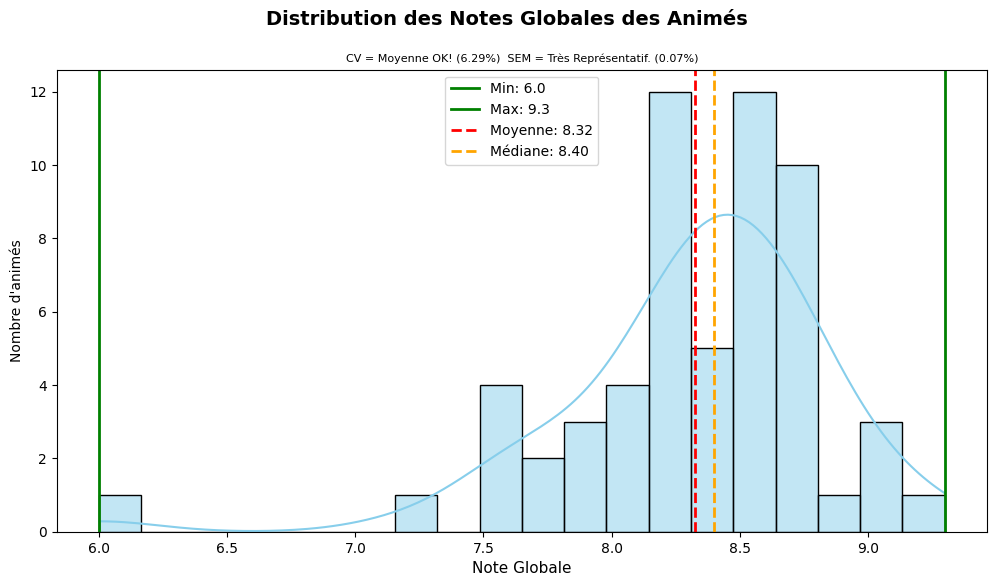

In [21]:
# Histogramme de la Note Globale
sem_note_globale = df['Note_Globale'].sem()
if sem_note_globale < 0.15:
    sem_verdict = "Très Représentatif."
elif sem_note_globale < 1.0:
    sem_verdict = "Assez Stable."
else:
    sem_verdict = "Peu Représentatif."

cv_note_globale = (df['Note_Globale'].std() / df['Note_Globale'].mean()) * 100
if cv_note_globale < 15:
    cv_verdict = "Moyenne OK!"
elif cv_note_globale <= 30:
    cv_verdict = "Mix Moy/Med"
else:
    cv_verdict = "Utiliser la MÉDIANE!"

print("\n--- Lancement de l'histogramme ---")
plt.figure(figsize=(12, 6))
sns.histplot(df['Note_Globale'], kde=True, color='skyblue', bins=20)

# 1. Amplitude (Min et Max)
min_note = df['Note_Globale'].min()
max_note = df['Note_Globale'].max()
plt.axvline(x=min_note, color='green', linestyle='-', linewidth=2, label=f'Min: {min_note}')
plt.axvline(x=max_note, color='green', linestyle='-', linewidth=2, label=f'Max: {max_note}')

# 2. Biais (Moyenne et Médiane)
mean_note = df['Note_Globale'].mean()
median_note = df['Note_Globale'].median()
plt.axvline(x=mean_note, color='red', linestyle='--', linewidth=2, label=f'Moyenne: {mean_note:.2f}')
plt.axvline(x=median_note, color='orange', linestyle='--', linewidth=2, label=f'Médiane: {median_note:.2f}')

# 3 Titres et Légendes
plt.suptitle("Distribution des Notes Globales des Animés", fontsize=14, fontweight='bold')
plt.title(f"CV = {cv_verdict} ({cv_note_globale:.2f}%)  SEM = {sem_verdict} ({sem_note_globale:.2f}%)", fontsize=8, fontweight='normal')
plt.xlabel("Note Globale", fontsize=11)
plt.ylabel("Nombre d'animés")
plt.legend()
save_graph("Distribution des Notes Globales des Animés.png")
plt.show()


# Analyse de l'Histogramme:

On peut constater que...



# 2. Histogramme des Meilleures, Pires et Notes Globales


--- Lancement de l'Histogramme des 3 Notes ---
💾 Graphique sauvegardé dans : c:\Users\D\Documents\Cours\Projet Data\Score_Editorial_Animes\img\Comparaison des Distributions des Notes


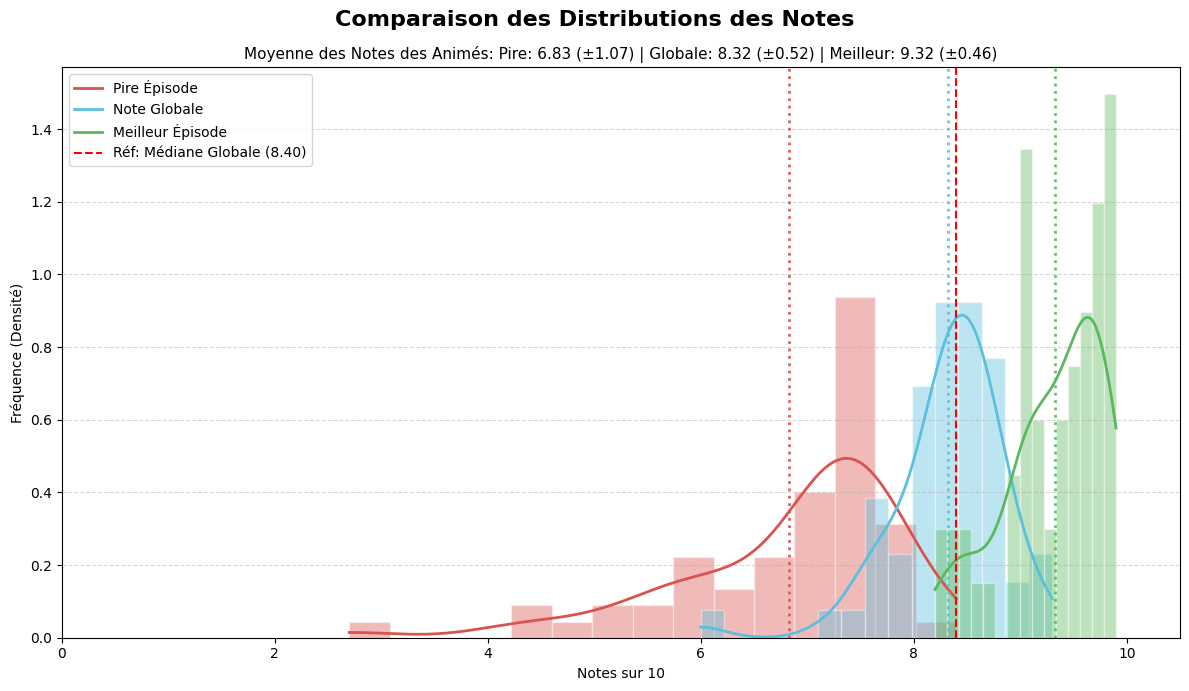

In [22]:
# 2. Histogramme des 3 Notes
print("\n--- Lancement de l'Histogramme des 3 Notes ---")

notes_pire = df['Note_Pire_Ep']
notes_globale = df['Note_Globale']
notes_meilleur = df['Note_Meilleur_Ep']

pire = f"Pire: {notes_pire.mean():.2f} (±{notes_pire.std():.2f})"
glob = f"Globale: {notes_globale.mean():.2f} (±{notes_globale.std():.2f})"
meill = f"Meilleur: {notes_meilleur.mean():.2f} (±{notes_meilleur.std():.2f})"

mediane_globale = df['Note_Globale'].median()

plt.figure(figsize=(12, 7))

def plot_distrib(data, color, label, title_stat):
    plt.hist(data, bins=15, alpha=0.4, color=color, density=True, edgecolor='white')
    density = gaussian_kde(data)
    xs = np.linspace(min(data), max(data), 200)
    plt.plot(xs, density(xs), color=color, linewidth=2, label=label)
    plt.axvline(data.mean(), color=color, linestyle=':', linewidth=2, alpha=0.9)

plot_distrib(notes_pire, '#D9534F', 'Pire Épisode', pire)    # Rouge
plot_distrib(notes_globale, '#5BC0DE', 'Note Globale', glob) # Bleu
plot_distrib(notes_meilleur, '#5CB85C', 'Meilleur Épisode', meill) # Vert

plt.axvline(mediane_globale, color='red', linestyle='--', linewidth=1.5, label=f'Réf: Médiane Globale ({mediane_globale:.2f})')
plt.title(f"Moyenne des Notes des Animés: {pire} | {glob} | {meill}", fontsize=11)
plt.suptitle("Comparaison des Distributions des Notes", fontsize=16, fontweight='bold')
plt.xlabel("Notes sur 10")
plt.ylabel("Fréquence (Densité)")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.xlim(0, 10.5)
plt.tight_layout()
save_graph("Comparaison des Distributions des Notes")
plt.show()


# Analyse:

On peut constater que...

# 3. Boxplot


--- Lancement du boxplot ---


C:\Users\D\AppData\Local\Temp\ipykernel_6732\3592037095.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data.values, vert=False, patch_artist=True, showmeans=True, labels=labels_notes)


💾 Graphique sauvegardé dans : c:\Users\D\Documents\Cours\Projet Data\Score_Editorial_Animes\img\Boxplot Notes


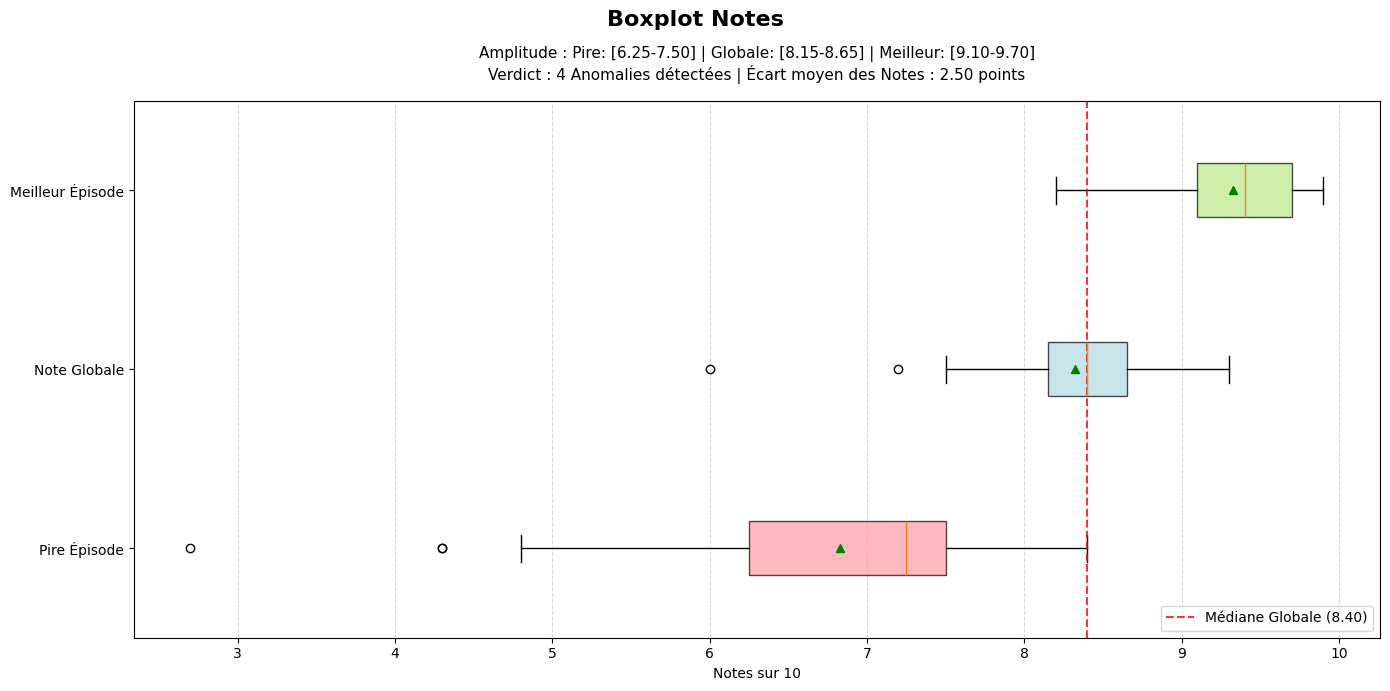

In [23]:
# 3. Boîte à moustaches (Boxplot)
print("\n--- Lancement du boxplot ---")

cols = ['Note_Pire_Ep', 'Note_Globale', 'Note_Meilleur_Ep']
data = df[cols]
labels_notes = ['Pire Épisode', 'Note Globale', 'Meilleur Épisode']

Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
mediane_globale = df['Note_Globale'].median()
IQR = Q3 - Q1
seuil_bas = Q1 - (1.5 * IQR)
seuil_haut = Q3 + (1.5 * IQR)
nb_outliers = ((data < seuil_bas) | (data > seuil_haut)).any(axis=1).sum()
verdict = "Pas d'anomalies" if nb_outliers == 0 else f"{nb_outliers} Anomalies détectées"

pire_ep = f"Pire: [{Q1['Note_Pire_Ep']:.2f}-{Q3['Note_Pire_Ep']:.2f}]"
note_global = f"Globale: [{Q1['Note_Globale']:.2f}-{Q3['Note_Globale']:.2f}]"
meilleur_ep = f"Meilleur: [{Q1['Note_Meilleur_Ep']:.2f}-{Q3['Note_Meilleur_Ep']:.2f}]"

plt.figure(figsize=(14, 7))
box = plt.boxplot(data.values, vert=False, patch_artist=True, showmeans=True, labels=labels_notes)

colors = ['#FF9AA2', '#AED9E0', '#B8E986']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

for mean in box['means']:
    mean.set(marker='^', markeredgecolor='green', markerfacecolor='green')

plt.axvline(mediane_globale, color='red', linestyle='--', linewidth=1.5, alpha=0.8, label=f'Médiane Globale ({mediane_globale:.2f})')
plt.title(
    f"Amplitude : {pire_ep} | {note_global} | {meilleur_ep}\n"
    f"Verdict : {verdict} | Écart moyen des Notes : {df['Ecart_Notes'].mean():.2f} points",
    fontsize=11, pad=15
)
plt.suptitle("Boxplot Notes", fontsize=16, fontweight='bold')
plt.xlabel("Notes sur 10")
plt.legend(loc='lower right')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
save_graph("Boxplot Notes")
plt.show()

# Analyse du Boxplot

On peut constater que...

# 4. Scatter Plot


--- Lancement du Scatter Plot ---
💾 Graphique sauvegardé dans : c:\Users\D\Documents\Cours\Projet Data\Score_Editorial_Animes\img\Scatter Plot PIRE VS MEILLEUR


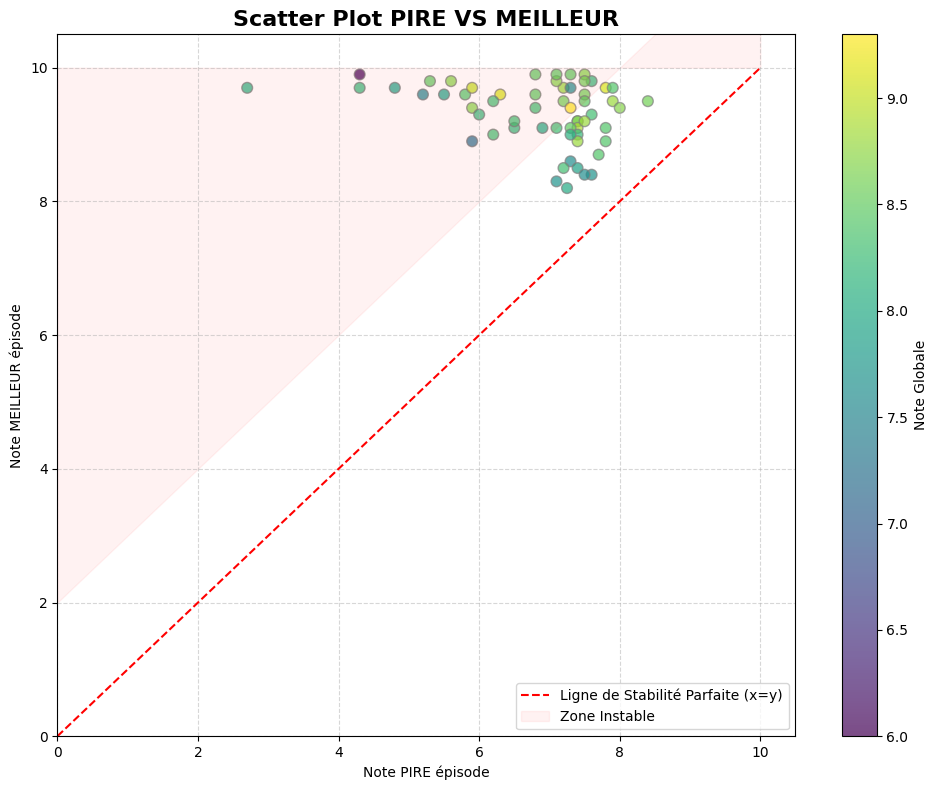

In [24]:
print("\n--- Lancement du Scatter Plot ---")

x = df['Note_Pire_Ep']
y = df['Note_Meilleur_Ep']
colors_scatter = df['Note_Globale']

plt.figure(figsize=(10, 8))
scatter = plt.scatter(x, y, c=colors_scatter, cmap='viridis', alpha=0.7, edgecolors='grey', s=60)
plt.plot([0, 10], [0, 10], color='red', linestyle='--', label='Ligne de Stabilité Parfaite (x=y)')
x_fill = np.linspace(0, 10, 100)
plt.fill_between(x_fill, x_fill + 2, 10, color='red', alpha=0.05, label='Zone Instable')
plt.colorbar(scatter, label='Note Globale')
plt.title("Scatter Plot PIRE VS MEILLEUR", fontsize=16, fontweight='bold')
plt.xlabel("Note PIRE épisode")
plt.ylabel("Note MEILLEUR épisode")
plt.xlim(0, 10.5)
plt.ylim(0, 10.5)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(loc='lower right')
plt.tight_layout()
save_graph("Scatter Plot PIRE VS MEILLEUR")
plt.show()

# Analyse

On peut constater que...

# Corrélation Longueur d'un Episode par rapport à sa Note Globale


--- Analyse de la corrélation Longueur / Note ---
Coefficient de corrélation : -0.0722
>> VERDICT : Aucune corrélation significative. L'hypothèse est VALIDÉE.
💾 Graphique sauvegardé dans : c:\Users\D\Documents\Cours\Projet Data\Score_Editorial_Animes\img\Correlation Longueur & Note Globale


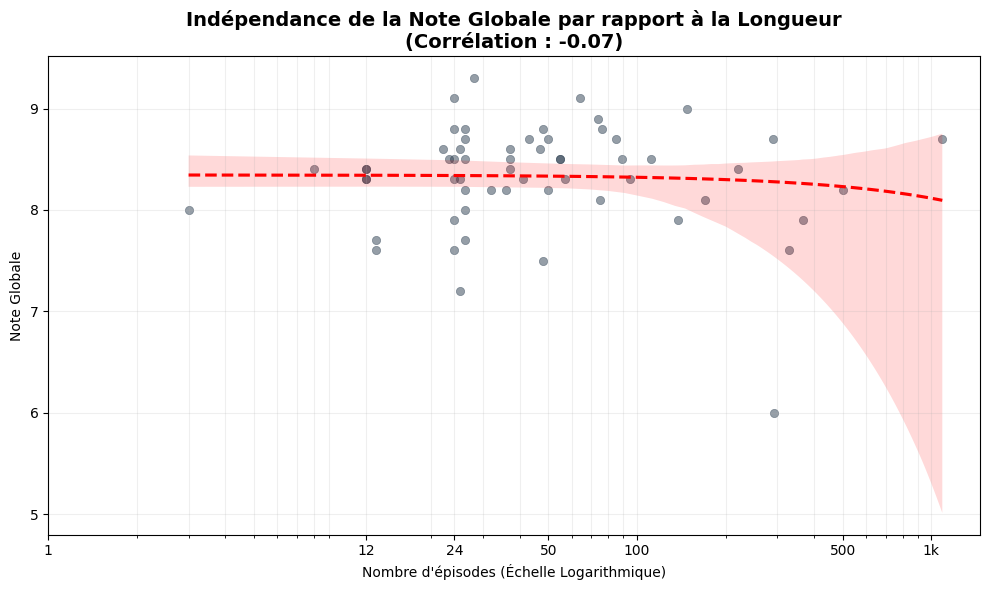

In [25]:
print("\n--- Analyse de la corrélation Longueur / Note ---")

df_correlation = df[df['Nb_Episodes'] > 0].copy()

correlation = df_correlation['Nb_Episodes'].corr(df_correlation['Note_Globale'])
print(f"Coefficient de corrélation : {correlation:.4f}")

if abs(correlation) < 0.1:
    print(">> VERDICT : Aucune corrélation significative. L'hypothèse est VALIDÉE.")
elif abs(correlation) < 0.3:
    print(">> VERDICT : Faible corrélation.")
else:
    print(">> VERDICT : Attention, il y a une corrélation notable.")

plt.figure(figsize=(10, 6))

sns.scatterplot(
    data=df_correlation, 
    x='Nb_Episodes', 
    y='Note_Globale', 
    alpha=0.5, 
    edgecolor=None,
    color='#2c3e50'
)

sns.regplot(
    data=df_correlation, 
    x='Nb_Episodes', 
    y='Note_Globale', 
    scatter=False, 
    color='red', 
    line_kws={'linestyle':'--'}
)

plt.xscale('log')
plt.title(f"Indépendance de la Note Globale par rapport à la Longueur\n(Corrélation : {correlation:.2f})", fontsize=14, fontweight='bold')
plt.xlabel("Nombre d'épisodes (Échelle Logarithmique)")
plt.ylabel("Note Globale")

plt.xticks([1, 12, 24, 50, 100, 500, 1000], ['1', '12', '24', '50', '100', '500', '1k'])
plt.grid(True, which="both", ls="-", alpha=0.2)

plt.tight_layout()
save_graph("Correlation Longueur & Note Globale")
plt.show()

# 📊 Construction du Score Editorial

Dans le cadre de ce projet, nous avons testé **6 formules de pondération** pour construire le **Score Éditorial**.  
L'objectif est de transformer des données brutes en un **signal de qualité fiable** pour la recommandation.

---

## 🔢 Variables utilisées

- **$G$ (Globale)** : La moyenne des avis utilisateurs.  
- **$R$ (Régularité)** : Calculée via `10 - (Meilleur - Pire)`. Punit l'irrégularité.  
- **$P$ (Pic)** : La note du meilleur épisode.

---

## 1. Formule A :

**Pondération :**  
`0.5 G  |  0.4 R  |  0.1 P`

**Philosophie :**  
La sécurité avant tout. Une bonne série est une série constante.

✅ **Avantages :**  
Très sûr pour éviter le churn. Élimine impitoyablement les séries qui s'effondrent à la fin ou qui ont des saisons "bâclées".

❌ **Inconvénients :**  
Trop rigide. Elle pénalise les œuvres à "montagnes russes" (type Shonen longs) qui peuvent être culte malgré des épisodes de remplissage.

---

## 2. Formule B :

**Pondération :**  
`0.5 G  |  0.3 R  |  0.2 P`

**Philosophie :**  
On pardonne les défauts si le sommet est haut.

✅ **Avantages :**  
Met en valeur les animés "phénomènes" et les finaux explosifs.

❌ **Inconvénients :**  
Risqué pour le business. Recommande des animés potentiellement frustrants (3 épisodes géniaux, 10 mauvais).  
Ne répond pas à la contrainte de stabilité du client.

---

## 3. Formule C : 

**Pondération :**  
`0.5 G  |  0.35 R  |  0.15 P`

**Philosophie :**  
Essayer de satisfaire tout le monde.

✅ **Avantages :**  
Équilibrée, ne prend pas de risque mathématique.

❌ **Inconvénients :**  
Manque de caractère. Le score final reste trop proche de la moyenne brute, ce qui réduit la valeur ajoutée du travail de Data Science.

---

## 4. Formule D :

**Pondération :**  
`0.6 G  |  0.3 R  |  0.1 P`

**Philosophie :**  
La moyenne des utilisateurs a (presque) toujours raison.

✅ **Avantages :**  
Score très facile à justifier car collé à la réalité des notes existantes.

❌ **Inconvénients :**  
Inutile. Elle ne corrige pas les biais de la note globale.  
Si l'objectif est juste de reproduire la moyenne, l'algorithme ne sert à rien.

---


## 5. Formule E :

**Pondération :**  
`0.40 G  |  0.45 R  |  0.15 P`

**Philosophie :**  
La régularité est plus importante que la moyenne affichée.

✅ **Avantages :**  
Crée un classement très différent et "propre".  
Démasque les séries surcotées.  
Idéal pour une sélection "Premium / Curated".

❌ **Inconvénients :**  
Peut être perçue comme trop sévère envers les blockbusters grand public un peu inégaux.

---

## 6. Formule F : (Retenue 🏆)

**Pondération :**  
`0.45 G  |  0.40 R  |  0.15 P`

**Philosophie :**  
L'équilibre parfait entre respect de l'avis utilisateur et exigence de qualité.

✅ **Avantages :**  
- **Business-Ready** : Garde la Note Globale comme pilier principal (45%), ce qui rassure.  
- **Filtre Qualité** : La forte pondération Régularité (40%) garantit que les recommandations sont "binge-watchables" sans risque.  
- **Bonus Hype** : Les 15% de Pic permettent de départager les égalités par le haut.

❌ **Inconvénients :**  
Demande un tuning précis des données en entrée (nettoyage des outliers) pour être parfaite.

---

## 📝 Conclusion & Choix

Pour ce projet, nous retenons la **Formule F**.  
Elle répond le mieux à la problématique métier : identifier des animés sûrs (Régularité 40%) tout en respectant la popularité existante (Globale 45%), offrant ainsi le **meilleur ratio Risque / Qualité** pour la plateforme de streaming.


# Calcul du Score Éditorial

In [26]:

NOTE_G = 0.45
NOTE_R = 0.40
NOTE_P = 0.15

df['Score_Editorial'] = (
    (df['Note_Globale'] * NOTE_G) +
    (df['Regularite_Notes'] * NOTE_R) +
    (df['Note_Meilleur_Ep'] * NOTE_P)
)

df['Score_Editorial'] = df['Score_Editorial'].round(2)


print("✅ Score Éditorial calculé avec succès.")
print("\n--- Top 10 selon le Score Éditorial ---")
display(df[['Anime', 'Note_Pire_Ep', 'Note_Meilleur_Ep', 'Note_Globale','Regularite_Notes', 'Score_Editorial']]
        .sort_values(by='Score_Editorial', ascending=False)
        .head(10))

✅ Score Éditorial calculé avec succès.

--- Top 10 selon le Score Éditorial ---


,Anime,Note_Pire_Ep,Note_Meilleur_Ep,Note_Globale,Regularite_Notes,Score_Editorial
41,Your Lie in April,8.4,9.5,8.6,8.9,8.86
21,Steins;Gate,7.8,9.7,9.1,8.1,8.79
31,Mushishi,8.0,9.4,8.7,8.6,8.76
35,Frieren: Beyond Journey's End,7.3,9.4,9.3,7.9,8.76
13,Les Carnets de l'apothicaire,7.9,9.5,8.8,8.4,8.75
51,Vinland Saga,7.4,8.9,8.8,8.5,8.70
42,Monster,7.4,9.1,8.9,8.3,8.69
50,Chainsaw Man,7.7,8.7,8.4,9.0,8.68
15,Du mouvement de la Terre,7.8,8.9,8.4,8.9,8.68
43,Hajime no Ippo,7.5,9.2,8.8,8.3,8.66


# Segmentation Éditoriale

In [27]:
def definir_categorie(row):
    score = row['Score_Editorial']
    note = row['Note_Globale']
    reg = row['Regularite_Notes']
    
    if score >= 8.5:
        return "💎 Chef-d'œuvre (Valeur Sûre)"
    
    elif score >= 7.5:
        return "✅ Recommandation Prioritaire"
    
    elif note >= 7.5 and reg < 5.0:
        return "⚠️ Culte mais Irrégulier (Risqué)"
        
    elif score >= 6.0:
        return "🆗 Correct / Passable"
    
    else:
        return "⛔ À Éviter (Faible qualité ou trop instable)"

df['Categorie_Editoriale'] = df.apply(definir_categorie, axis=1)

print("\n--- Répartition des Animés par Catégorie ---")
print(df['Categorie_Editoriale'].value_counts())


--- Répartition des Animés par Catégorie ---
Categorie_Editoriale
✅ Recommandation Prioritaire                    39
💎 Chef-d'œuvre (Valeur Sûre)                    13
🆗 Correct / Passable                             4
⚠️ Culte mais Irrégulier (Risqué)                2
⛔ À Éviter (Faible qualité ou trop instable)     1
Name: count, dtype: int64


# Note Globale vs Score Editorial

Analyse des Mouvements: Qui Monte? Qui Descends?



In [28]:

top_10_global = set(df.sort_values(by='Note_Globale', ascending=False).head(10)['Anime'])
top_10_editorial = set(df.sort_values(by='Score_Editorial', ascending=False).head(10)['Anime'])


les_survivants = top_10_global.intersection(top_10_editorial) 
les_heureux_elus = top_10_editorial - top_10_global          
les_disparus = top_10_global - top_10_editorial             


print(f"📊 ANALYSE DES MOUVEMENTS DU TOP 10\n")

print(f"LES INDÉBOULONNABLES ({len(les_survivants)} animés)")
print(f"Ils mettent tout le monde d'accord : {', '.join(les_survivants)}\n")

print(f"🚀 LES HEUREUX ÉLUS ({len(les_heureux_elus)} animés)")
print("Ces pépites entrent dans le Top grâce à leur stabilité exemplaire :")
for anime in les_heureux_elus:
    note = df[df['Anime'] == anime]['Note_Globale'].values[0]
    reg = df[df['Anime'] == anime]['Regularite_Notes'].values[0]
    print(f"  - {anime} (Note: {note} -> Régularité: {reg})")

print(f"\n📉 LES TRISTEMENT DISPARUS ({len(les_disparus)} animés)")
print("Ces géants ont été sanctionnés pour leur irrégularité :")
for anime in les_disparus:
    note = df[df['Anime'] == anime]['Note_Globale'].values[0]
    reg = df[df['Anime'] == anime]['Regularite_Notes'].values[0]
    print(f"  - {anime} (Note: {note} ! -> Régularité: {reg})")

📊 ANALYSE DES MOUVEMENTS DU TOP 10

LES INDÉBOULONNABLES (6 animés)
Ils mettent tout le monde d'accord : Les Carnets de l'apothicaire, Frieren: Beyond Journey's End, Vinland Saga, Steins;Gate, Monster, Hajime no Ippo

🚀 LES HEUREUX ÉLUS (4 animés)
Ces pépites entrent dans le Top grâce à leur stabilité exemplaire :
  - Mushishi (Note: 8.7 -> Régularité: 8.6)
  - Your Lie in April (Note: 8.6 -> Régularité: 8.9)
  - Du mouvement de la Terre (Note: 8.4 -> Régularité: 8.899999999999999)
  - Chainsaw Man (Note: 8.4 -> Régularité: 9.0)

📉 LES TRISTEMENT DISPARUS (4 animés)
Ces géants ont été sanctionnés pour leur irrégularité :
  - Haikyuu!! (Note: 8.7 ! -> Régularité: 7.6)
  - Fullmetal Alchemist: Brotherhood (Note: 9.1 ! -> Régularité: 6.7)
  - Cowboy Bebop (Note: 8.8 ! -> Régularité: 7.500000000000001)
  - Hunter x Hunter (2011) (Note: 9.0 ! -> Régularité: 6.200000000000001)


💾 Graphique sauvegardé dans : c:\Users\D\Documents\Cours\Projet Data\Score_Editorial_Animes\img\Note Global vs Score Editorial


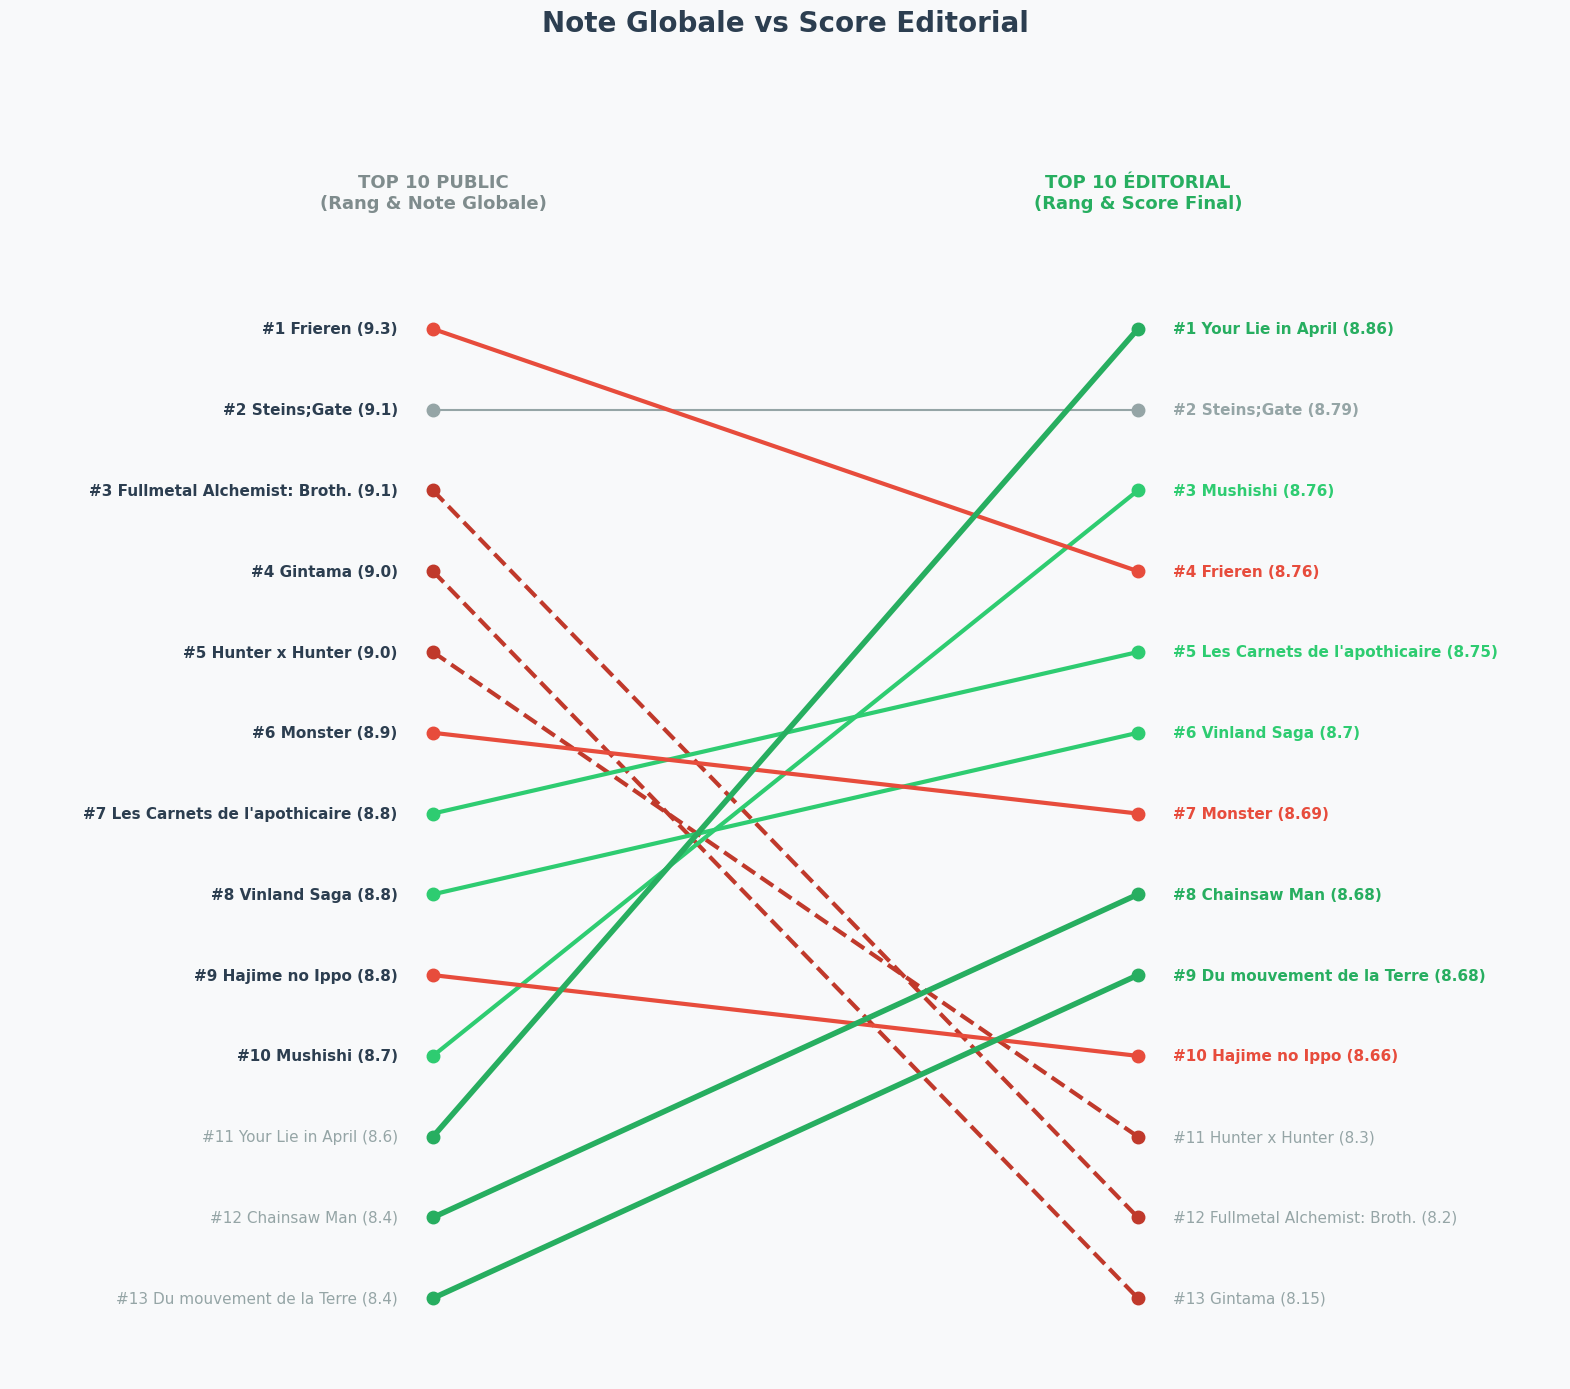

In [29]:
import pandas as pd
import matplotlib.pyplot as plt

data = {
    "Anime": [
        "Your Lie in April", "Steins;Gate", "Mushishi", "Frieren",
        "Les Carnets de l'apothicaire", "Vinland Saga", "Monster",
        "Chainsaw Man", "Du mouvement de la Terre", "Hajime no Ippo",
        "Fullmetal Alchemist: Broth.", "Gintama", "Hunter x Hunter"
    ],
    "Note_Globale": [
        8.6, 9.1, 8.7, 9.3,
        8.8, 8.8, 8.9,
        8.4, 8.4, 8.8,
        9.1, 9.0, 9.0
    ],
    "Score_Editorial": [
        8.86, 8.79, 8.76, 8.76,
        8.75, 8.70, 8.69,
        8.68, 8.68, 8.66,
        8.20, 8.15, 8.30
    ]
}

df_viz = pd.DataFrame(data)

# method='first' pour avoir des rangs uniques (1, 2, 3...) sans égalité pour l'affichage
df_viz['Rang_Global'] = df_viz['Note_Globale'].rank(ascending=False, method='first')
df_viz['Rang_Editorial'] = df_viz['Score_Editorial'].rank(ascending=False, method='first')

df_final = df_viz[(df_viz['Rang_Global'] <= 10) | (df_viz['Rang_Editorial'] <= 10)].copy()

# 4. Création du Graphique
plt.figure(figsize=(16, 14), facecolor='#f8f9fa')
ax = plt.gca()
ax.set_facecolor='#f8f9fa'

left_x, right_x = 1, 2

# Boucle de tracé
for i, row in df_final.iterrows():
    r_global = int(row['Rang_Global'])
    r_edito = int(row['Rang_Editorial'])
    note_glob = row['Note_Globale']
    score_edito = row['Score_Editorial']
    
    in_top_global = r_global <= 10
    in_top_edito = r_edito <= 10
    
    # --- STYLE & COULEURS ---
    if not in_top_global and in_top_edito: # 
        color = '#27ae60' 
        linewidth = 4
        style = '-'
        zorder = 4
    elif in_top_global and not in_top_edito: # SORTIE
        color = '#c0392b' 
        linewidth = 3
        style = '--'
        zorder = 2
    elif r_edito < r_global: # MONTE
        color = '#2ecc71' 
        linewidth = 3
        style = '-'
        zorder = 3
    elif r_edito > r_global: # DESCEND
        color = '#e74c3c' 
        linewidth = 3
        style = '-'
        zorder = 3
    else: # STABLE
        color = '#95a5a6'
        linewidth = 1.5
        style = '-'
        zorder = 1

    # Tracé de la ligne
    plt.plot([left_x, right_x], [r_global, r_edito], 
             color=color, linewidth=linewidth, linestyle=style, marker='o', markersize=9, zorder=zorder)

    
    # GAUCHE : Classement Public
    font_g = 'bold' if in_top_global else 'normal'
    color_g = '#2c3e50' if in_top_global else '#95a5a6'
    
    label_left = f"#{r_global} {row['Anime']} ({note_glob})"
    
    plt.text(left_x - 0.05, r_global, label_left, 
             ha='right', va='center', fontsize=11, fontweight=font_g, color=color_g)

    # DROITE : Classement Éditorial
    font_e = 'bold' if in_top_edito else 'normal'
    color_e = color if in_top_edito else '#95a5a6'
    
    label_right = f"#{r_edito} {row['Anime']} ({score_edito})"
    
    plt.text(right_x + 0.05, r_edito, label_right, 
             ha='left', va='center', fontsize=11, fontweight=font_e, color=color_e)

plt.title("Note Globale vs Score Editorial", fontsize=20, fontweight='bold', pad=40, color='#2c3e50')
plt.text(left_x, -0.5, "TOP 10 PUBLIC\n(Rang & Note Globale)", ha='center', fontsize=13, fontweight='bold', color='#7f8c8d')
plt.text(right_x, -0.5, "TOP 10 ÉDITORIAL\n(Rang & Score Final)", ha='center', fontsize=13, fontweight='bold', color='#27ae60')

plt.xlim(0.4, 2.6)
# Ajustement de l'échelle verticale pour tout voir
max_rank = max(df_final['Rang_Global'].max(), df_final['Rang_Editorial'].max())
plt.ylim(max_rank + 1, -2) # Inversion de l'axe Y + marge

plt.axis('off')
plt.tight_layout()
save_graph("Note Global vs Score Editorial")
plt.show()

In [30]:

def generer_audit(df, colonne_analyse, min_count=2):
    groupe = df.groupby(colonne_analyse)[['Note_Globale', 'Score_Editorial', 'Regularite_Notes']].mean()
    groupe['Nombre_Animes'] = df[colonne_analyse].value_counts()
    groupe = groupe[groupe['Nombre_Animes'] >= min_count]
    groupe['Impact'] = groupe['Score_Editorial'] - groupe['Note_Globale']
    return groupe.sort_values(by='Impact', ascending=False)

# --- TABLEAU 1 : ANALYSE PAR SOURCE (Manga vs Original vs Novel) ---
print("\n📊 AUDIT 1 : D'où viennent les meilleurs animés ? (Source)")
audit_source = generer_audit(df, 'Source', min_count=1)
display(audit_source.style.background_gradient(subset=['Impact'], cmap='RdYlGn', vmin=-0.3, vmax=0.3).format("{:.2f}"))

# --- TABLEAU 2 : ANALYSE PAR STUDIO (Qui travaille le mieux ?) ---
print("\n🏢 AUDIT 2 : Quels studios assurent la qualité technique ? (Studio)")
audit_studio = generer_audit(df, 'Studio') 
display(audit_studio.style.background_gradient(subset=['Impact'], cmap='RdYlGn', vmin=-0.5, vmax=0.5).format("{:.2f}"))

# --- TABLEAU 3 : ANALYSE PAR STATUS (Fini vs En Cours)
print("\n⏳ AUDIT 3 : Le risque des séries non terminées (Status)")
audit_status = generer_audit(df, 'Status', min_count=1)
display(audit_status.style.background_gradient(subset=['Impact'], cmap='RdYlGn', vmin=-0.2, vmax=0.2).format("{:.2f}"))


📊 AUDIT 1 : D'où viennent les meilleurs animés ? (Source)


,Note_Globale,Score_Editorial,Regularite_Notes,Nombre_Animes,Impact
Source,,,,,
Light Novel,8.10,8.20,7.90,4.00,0.10
Manga,8.30,8.12,7.47,48.00,-0.18
Original,8.57,8.31,7.58,4.00,-0.26
Visual Novel,9.10,8.79,8.10,1.00,-0.31
Web Manga,8.50,8.14,7.20,1.00,-0.36
Manhwa,8.30,7.84,6.70,1.00,-0.46



🏢 AUDIT 2 : Quels studios assurent la qualité technique ? (Studio)


,Note_Globale,Score_Editorial,Regularite_Notes,Nombre_Animes,Impact
Studio,,,,,
Mappa,8.23,8.44,8.50,3.00,0.21
A-1 Pictures,7.93,8.07,7.78,6.00,0.14
Bones,8.20,8.12,7.64,5.00,-0.08
Production I.G,8.37,8.27,7.73,3.00,-0.10
White Fox,8.65,8.54,7.95,2.00,-0.11
Madhouse,8.55,8.42,8.01,11.00,-0.12
Wit Studio / Mappa,8.65,8.38,7.70,2.00,-0.27
Ufotable,8.50,8.23,7.30,2.00,-0.27
Sunrise,8.75,8.36,7.40,2.00,-0.39



⏳ AUDIT 3 : Le risque des séries non terminées (Status)


,Note_Globale,Score_Editorial,Regularite_Notes,Nombre_Animes,Impact
Status,,,,,
En Cours,8.31,8.27,7.86,22.00,-0.04
Fini,8.40,8.18,7.50,35.00,-0.22
En Pause,7.05,6.12,3.70,2.00,-0.93


# 1. Audit Source

Les "Light Novels" (+0.10) sont les seuls à être "Verts". 

Les "Originals" (-0.26) et "Visual Novel" (-0.31) sont lourdement sanctionnés.

Contrairement aux idées reçues, les scénarios originaux ou issus de jeux vidéo (Visual Novel) sont les plus instables. 

Pour minimiser le risque de déception, la plateforme doit privilégier l'acquisition de licences issues de Light Novels, qui affichent la meilleure régularité (7.90)."

# 2. Audit Studio

Les "Modernes" (Mappa, A-1) sont en positif (+0.21, +0.14).

Les "Historiques" (Toei, Pierrot) se font écraser (-0.89, -0.65).

L'algorithme a détecté une faille structurelle chez les studios historiques (Naruto, One Piece, Dragon Ball). 

Leur modèle de production 'longues séries' crée une irrégularité massive (~6.0). 

À l'inverse, Mappa (Jujutsu Kaisen, Chainsaw Man) maîtrise le format 'saisonnier' court et dense. 

Recommandation : Mettre en avant le catalogue "Mappa / A-1" sur la page d'accueil pour la rétention.

# 3. Audit Status

"En Cours" (-0.04) est beaucoup plus sûr que "Fini" (-0.22). 

"En Pause" est une catastrophe (-0.93).

On pourrait croire qu'une série finie est plus sûre. Faux! 

Les séries 'En Cours' bénéficient des standards de production modernes (plus courts, plus beaux). 

Les séries 'Finies' incluent beaucoup de vieux titres inégaux. 

Recommendation : Ne jamais mettre en avant une série 'En Pause'!


📏 AUDIT 4 : La taille compte-t-elle ? (Longueur)


,Note_Globale,Score_Editorial,Regularite_Notes,Nombre_Animes,Impact
Categorie_Longueur,,,,,
Court (1-13 ep),8.14,8.34,8.34,8.00,0.20
Moyen (14-26 ep),8.31,8.34,8.04,17.00,0.02
Long (27-100 ep),8.51,8.30,7.64,23.00,-0.21
Fleuve (100+ ep),8.09,7.39,5.77,11.00,-0.70


💾 Graphique sauvegardé dans : c:\Users\D\Documents\Cours\Projet Data\Score_Editorial_Animes\img\Correlation Longueur - Qualité


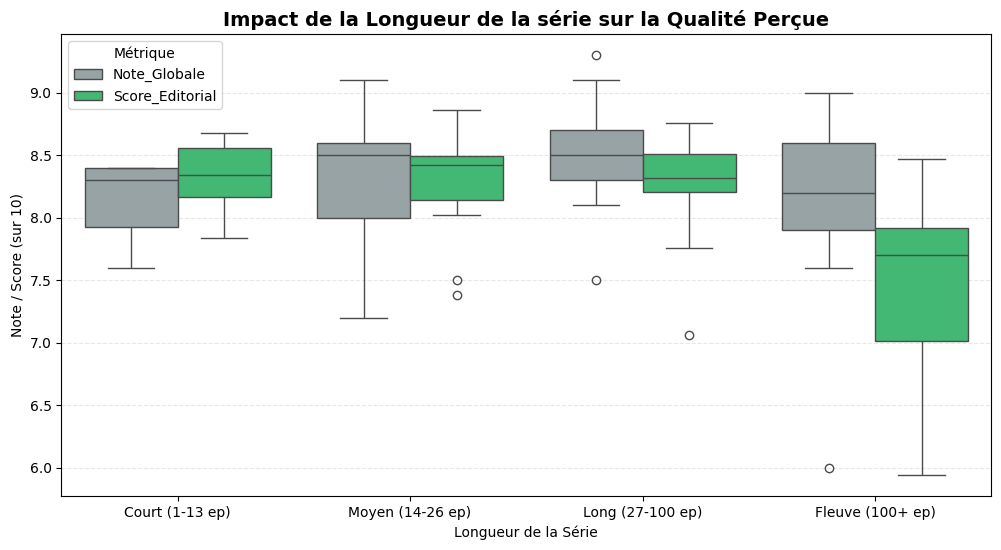

In [31]:
bins = [0, 13, 26, 100, 10000]
labels = ['Court (1-13 ep)', 'Moyen (14-26 ep)', 'Long (27-100 ep)', 'Fleuve (100+ ep)']

df['Categorie_Longueur'] = pd.cut(df['Nb_Episodes'], bins=bins, labels=labels)


print("\n📏 AUDIT 4 : La taille compte-t-elle ? (Longueur)")
audit_len = df.groupby('Categorie_Longueur', observed=False)[['Note_Globale', 'Score_Editorial', 'Regularite_Notes']].mean()
audit_len['Nombre_Animes'] = df['Categorie_Longueur'].value_counts()
audit_len['Impact'] = audit_len['Score_Editorial'] - audit_len['Note_Globale']
display(audit_len.style.background_gradient(subset=['Impact'], cmap='RdYlGn', vmin=-0.5, vmax=0.5).format("{:.2f}"))


plt.figure(figsize=(12, 6))

df_melt = df.melt(id_vars=['Categorie_Longueur'], 
                  value_vars=['Note_Globale', 'Score_Editorial'], 
                  var_name='Type_Note', value_name='Note')

sns.boxplot(data=df_melt, x='Categorie_Longueur', y='Note', hue='Type_Note', palette=['#95a5a6', '#2ecc71'])

plt.title("Impact de la Longueur de la série sur la Qualité Perçue", fontsize=14, fontweight='bold')
plt.ylabel("Note / Score (sur 10)")
plt.xlabel("Longueur de la Série")
plt.legend(title='Métrique')
plt.grid(axis='y', linestyle='--', alpha=0.3)
save_graph("Correlation Longueur - Qualité")
plt.show()

L'audit prouve mathématiquement qu'il existe une corrélation inverse entre la longueur et la qualité éditoriale. 

L'algorithme devra privilégier les formats courts (+0.20) et pénaliser lourdement les séries fleuves (-0.70).

💾 Graphique sauvegardé dans : c:\Users\D\Documents\Cours\Projet Data\Score_Editorial_Animes\img\WordCloud


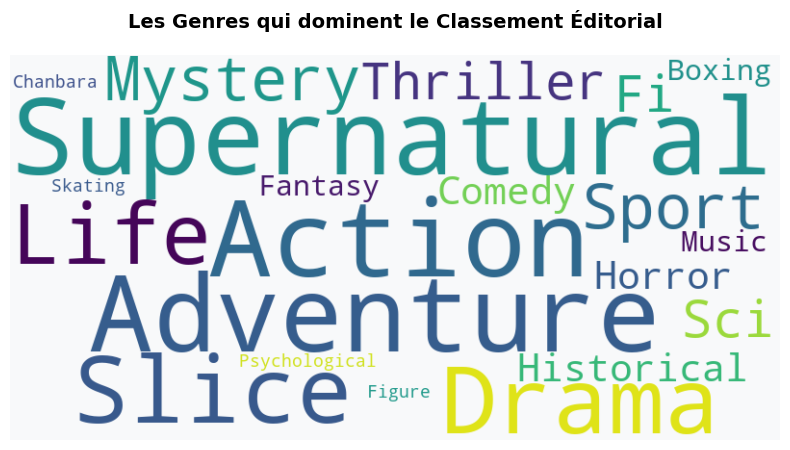

In [32]:
top_genres = df.sort_values(by='Score_Editorial', ascending=False).head(20)['Genre_Tags'].str.cat(sep=' ')

wordcloud = WordCloud(width=800, height=400, background_color='#f8f9fa', colormap='viridis').generate(top_genres)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Les Genres qui dominent le Classement Éditorial", fontsize=14, fontweight='bold', pad=20)
save_graph("WordCloud")
plt.show()

# 📊 STATISTIQUES DES GENRES 

In [33]:
top_20 = df.sort_values(by='Score_Editorial', ascending=False).head(20)

tous_les_genres = []
for tags in top_20['Genre_Tags']:
    if isinstance(tags, str):
        mots = tags.replace(' / ', '/').split('/') 
        tous_les_genres.extend([m.strip() for m in mots])

compteur = Counter(tous_les_genres)
total_animes = 20

print(f"Dans notre Top 20 des meilleurs scores :")
for genre, count in compteur.most_common(5):
    pourcentage = (count / total_animes) * 100
    print(f"- Le genre '{genre}' est présent dans {int(pourcentage)}% des meilleurs titres.")

Dans notre Top 20 des meilleurs scores :
- Le genre 'Supernatural' est présent dans 20% des meilleurs titres.
- Le genre 'Adventure' est présent dans 20% des meilleurs titres.
- Le genre 'Action' est présent dans 20% des meilleurs titres.
- Le genre 'Drama' est présent dans 15% des meilleurs titres.
- Le genre 'Slice of Life' est présent dans 15% des meilleurs titres.


In [34]:
def recommander_alternative(nom_anime):
    try:
        cible = df[df['Anime'] == nom_anime].iloc[0]
    except IndexError:
        return f"❌ L'animé '{nom_anime}' est introuvable."
    
    score_cible = cible['Score_Editorial']
    genre_principal = cible['Genre_Tags'].split('/')[0].strip() # Ex: "Action"
    
    print(f" Vous regardez : {nom_anime} (Score: {score_cible:.2f})")
    print(f" Genre : {genre_principal}")
    print(f" Voici 3 alternatives plus 'Sûres' (Meilleure Qualité/Régularité) :\n")
    
    candidats = df[
        (df['Genre_Tags'].str.contains(genre_principal, na=False)) & 
        (df['Score_Editorial'] > score_cible)
    ].copy()
    
    recos = candidats.sort_values(by='Score_Editorial', ascending=False).head(3)
    
    if recos.empty:
        print("   👑 C'est déjà le roi de sa catégorie ! Rien de mieux à proposer.")
    else:
        for i, row in recos.iterrows():
            gain = row['Score_Editorial'] - score_cible
            print(f"    {row['Anime']}")
            print(f"      Score : {row['Score_Editorial']:.2f} (+{gain:.2f} pts)")
            print(f"      Label : {row['Categorie_Editoriale']}")
            print("      ---")

print("--- TEST : Je veux mieux que 'Naruto' ---")
recommander_alternative("Naruto")

--- TEST : Je veux mieux que 'Naruto' ---
 Vous regardez : Naruto (Score: 7.70)
 Genre : Action
 Voici 3 alternatives plus 'Sûres' (Meilleure Qualité/Régularité) :

    Chainsaw Man
      Score : 8.68 (+0.98 pts)
      Label : 💎 Chef-d'œuvre (Valeur Sûre)
      ---
    Dan Da Dan
      Score : 8.52 (+0.82 pts)
      Label : 💎 Chef-d'œuvre (Valeur Sûre)
      ---
    Yū Yū Hakusho
      Score : 8.47 (+0.77 pts)
      Label : ✅ Recommandation Prioritaire
      ---


# DATASET FINAL

In [35]:
df['Anime'] = df['Anime'].astype(str).apply(lambda x: re.sub(r'\s+', ' ', x).strip())

nom_fichier = "animes_score_editorial_final.csv"
chemin_final = os.path.join(PROCESSED_DIR, nom_fichier)
df.to_csv(chemin_final, index=False, encoding='utf-8-sig')

print(f" PROJET TERMINÉ & SAUVEGARDÉ !")


 PROJET TERMINÉ & SAUVEGARDÉ !


In [36]:
! pip install python-pptx
from pptx import Presentation
from pptx.util import Inches, Pt
from pptx.enum.text import PP_ALIGN

# 1. Création de l'objet Présentation
prs = Presentation()

def add_slide(title, content, image_path=None):
    slide_layout = prs.slide_layouts[1] # Layout Titre + Contenu
    slide = prs.slides.add_slide(slide_layout)
    
    # Titre
    slide.shapes.title.text = title
    
    # Corps de texte
    tf = slide.placeholders[1].text_frame
    tf.text = content
    
    # Si une image est spécifiée et existe, on l'ajoute à droite
    if image_path and os.path.exists(image_path):
        # Positionnement de l'image (ajuster selon besoin)
        left = Inches(6)
        top = Inches(2)
        width = Inches(3.5)
        slide.shapes.add_picture(image_path, left, top, width=width)

# --- SLIDE 1 : TITRE ---
title_slide_layout = prs.slide_layouts[0]
slide = prs.slides.add_slide(title_slide_layout)
slide.shapes.title.text = "🎬 Score Éditorial Anime"
slide.shapes.placeholders[1].text = "Optimisation du Catalogue & Rétention Utilisateur\nPrésenté par David DAUPIN"

# --- SLIDE 2 : LE PROBLÈME MÉTIER ---
add_slide("📉 Le Problème : Le Churn post-clic", 
          "• La Note Globale est biaisée par la hype.\n"
          "• Les séries irrégulières frustrent les abonnés.\n"
          "• Risque : Désabonnement après une mauvaise expérience sur une série longue.")

# --- SLIDE 3 : LA SOLUTION ---
add_slide("💡 La Solution : Le Score Éditorial", 
          "Formule : 45% Note Globale + 40% Régularité + 15% Pic de Qualité\n\n"
          "• Priorise la stabilité narrative.\n"
          "• Détecte les pépites cachées.\n"
          "• Sanctionne le remplissage (fillers).")

# --- SLIDE 4 : ANALYSE DES SÉRIES FLEUVES ---
add_slide("1️⃣ La Malédiction des Séries Fleuves", 
          "• Impact moyen : -0.70 pts sur le score final.\n"
          "• Trop d'épisodes affaiblissent la rétention.\n"
          "• Exemple : Naruto, One Piece (sanctionnés par l'algorithme).",
          os.path.join(IMG_DIR, "correlation_longueur.png"))

# --- SLIDE 5 : LES LIGHT NOVELS ---
add_slide("2️⃣ Le Safe Bet : Light Novels", 
          "• Régularité moyenne la plus élevée (7.90/10).\n"
          "• Format plus stable que les scénarios 'Original'.\n"
          "• Recommandation : Acquisition prioritaire de ces licences.")

# --- SLIDE 6 : LE GRAND REMPLACEMENT ---
add_slide("3️⃣ Le Choc du Top 10", 
          "• Sortie : One Piece (Instabilité).\n"
          "• Entrée : Your Lie in April (Régularité parfaite).\n"
          "• Le score corrige les biais de popularité.",
          os.path.join(IMG_DIR, "slope_chart_score.png"))

# --- SLIDE 7 : SEGMENTATION ---
add_slide("💎 Classification du Catalogue", 
          "• Chef-d'œuvre : Score > 8.5 (Valeur Sûre).\n"
          "• Recommandation : Score > 7.5.\n"
          "• Risqué : Note haute mais Régularité < 5.0.")

# --- SLIDE 8 : IMPACT BUSINESS & ROI ---
add_slide("💰 ROI & Stratégie Financière", 
          "• Formule : ROI = (Gain Rétention - Coût) / Investissement.\n"
          "• Objectif : +1% de rétention = Seuil de rentabilité sous 3 mois.\n"
          "• Stratégie : Mise en avant du Top Éditorial en Page d'Accueil.")

# --- SLIDE 9 : AUDIT DES STUDIOS ---
add_slide("🏢 Performance des Studios", 
          "• Studios Modernes (Mappa, A-1) : Impact positif (+0.20).\n"
          "• Studios Historiques : Souffrent du format long.\n"
          "• Recommandation : Focus sur les productions saisonnières.")

# --- SLIDE 10 : LIMITES & ÉTHIQUE ---
add_slide("⚖️ Audit : Légal & Limites", 
          "• RGPD Compliant : 0 donnée personnelle.\n"
          "• Limite : Dépendance à la note utilisateur initiale.\n"
          "• Éthique : Risque de favoriser les genres 'grand public'.")

# --- SLIDE 11 : CONCLUSION ---
add_slide("🚀 Conclusion & Actions", 
          "• Implémentation du Score dans l'algorithme de recommandation.\n"
          "• Création d'un label 'Qualité Certifiée'.\n"
          "• Prochaine étape : Test A/B sur un segment d'utilisateurs.")

# Sauvegarde du fichier
file_name = "Presentation_Score_Editorial_Anime.pptx"
prs.save(file_name)
print(f"✅ Présentation générée avec succès : {file_name}")

Defaulting to user installation because normal site-packages is not writeable
✅ Présentation générée avec succès : Presentation_Score_Editorial_Anime.pptx
